<a href="https://colab.research.google.com/github/insancs/rock-paper-scissors-classifier/blob/main/rockpaperscissors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [1]:
# import libraries
import numpy as np
import zipfile
import os
import matplotlib.pyplot as plt
from google.colab import files
from keras.preprocessing import image
import matplotlib.image as mpimg
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import Callback
# Check tensorflow version
print(tf.__version__)

2.6.0


# Import Dataset

In [2]:
# import datasets
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps.zip \
    -O /tmp/rps.zip

!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps-test-set.zip \
    -O /tmp/rps-test-set.zip

--2021-10-14 05:40:29--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 173.194.202.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 200682221 (191M) [application/zip]
Saving to: ‘/tmp/rps.zip’

/tmp/rps.zip        100%[===================>] 191.38M   138MB/s    in 1.4s    

2021-10-14 05:40:30 (138 MB/s) - ‘/tmp/rps.zip’ saved [200682221/200682221]

--2021-10-14 05:40:31--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps-test-set.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 142.250.107.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29516758 (28M) [application/zip]
Saving to: ‘/t

# Extract file

In [3]:
# Extract zip file
local_zip = '/tmp/rps.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/')
zip_ref.close()

local_zip = '/tmp/rps-test-set.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/')
zip_ref.close()

In [4]:
# Check rps directory
os.listdir('/tmp/rps')

['rock', 'scissors', 'paper']

In [5]:
# Check rps-test-set direcroty
os.listdir('/tmp/rps-test-set')

['rock', 'scissors', 'paper']

# Image Augmentation

In [6]:
# image augmentation
train_datagen = ImageDataGenerator(
    rescale = 1./255,
	  rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
)

validation_datagen = ImageDataGenerator(
    rescale = 1./255,
)

In [7]:
TRAINING_DIR = "/tmp/rps/"
train_generator = train_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size = (150, 150),
    batch_size=32,
    class_mode='categorical',
)

VALIDATION_DIR = "/tmp/rps-test-set/"
validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size = (150, 150),
    batch_size = 32,
    class_mode = 'categorical',
)

Found 2520 images belonging to 3 classes.
Found 372 images belonging to 3 classes.


# Convolution Neural Network

In [8]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

# Tampilkan summary model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

In [9]:
# Compile model
model.compile(loss = 'categorical_crossentropy', 
              optimizer='rmsprop',
              metrics=['accuracy'])

# Create Callbacks

In [10]:
# Buat callback kostumisasi
class CustomCallback(Callback):
    def on_train_begin(self, logs=None):
        print("Starting training")

    def on_train_end(self, logs=None):
        print("Training has been stopped")
        print('Accuracy = %2.2f%%' %(logs['accuracy']*100))

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2,
    patience=5, 
    min_lr=1.5e-5
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=12,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True
)

In [11]:
history = model.fit(train_generator, 
                    epochs=30,
                    steps_per_epoch=20,
                    validation_data = validation_generator,
                    verbose = 1,
                    validation_steps=3,
                    callbacks=[CustomCallback(), reduce_lr, early_stopping]
                    )

Starting training
Epoch 1/30
20/20 [==============================] - 44s 2s/step - loss: 1.3408 - accuracy: 0.3719 - val_loss: 1.0886 - val_accuracy: 0.4271
Epoch 2/30
20/20 [==============================] - 43s 2s/step - loss: 1.1108 - accuracy: 0.3781 - val_loss: 1.1073 - val_accuracy: 0.3854
Epoch 3/30
20/20 [==============================] - 42s 2s/step - loss: 1.0841 - accuracy: 0.4430 - val_loss: 0.8570 - val_accuracy: 0.4896
Epoch 4/30
20/20 [==============================] - 42s 2s/step - loss: 1.1040 - accuracy: 0.5016 - val_loss: 1.1516 - val_accuracy: 0.3854
Epoch 5/30
20/20 [==============================] - 42s 2s/step - loss: 0.9057 - accuracy: 0.5491 - val_loss: 0.5212 - val_accuracy: 0.8750
Epoch 6/30
20/20 [==============================] - 42s 2s/step - loss: 0.8866 - accuracy: 0.5906 - val_loss: 0.4690 - val_accuracy: 0.8125
Epoch 7/30
20/20 [==============================] - 42s 2s/step - loss: 0.7362 - accuracy: 0.6500 - val_loss: 0.3730 - val_accuracy: 0.8333
Ep

# Model Evaluate

In [12]:
# Evaluasi model pada training data
print("Evaluasi train data")
results = model.evaluate(train_generator, batch_size=32)
print('Loss: {:.4f}'.format(results[0]))
print('Accuracy: {:.2f}%'.format(results[1]*100))

Evaluasi train data
79/79 [==============================] - 54s 679ms/step - loss: 0.0818 - accuracy: 0.9766
Loss: 0.0818
Accuracy: 97.66%


In [13]:
# Evaluasi model pada validation data
print("Evaluasi validation data")
results = model.evaluate(validation_generator, batch_size=32)
print('Loss: {:.4f}'.format(results[0]))
print('Accuracy: {:.2f}%'.format(results[1]*100))

Evaluasi validation data
12/12 [==============================] - 6s 522ms/step - loss: 0.0468 - accuracy: 0.9785
Loss: 0.0468
Accuracy: 97.85%


# Plotting Loss and Accuracy

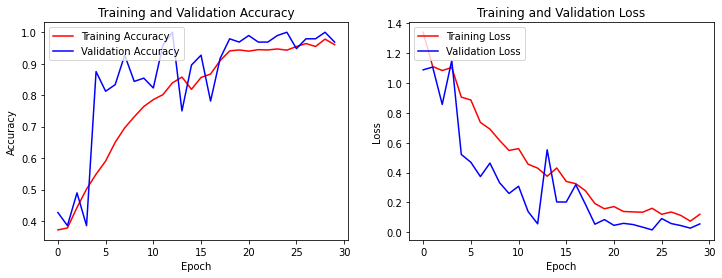

In [14]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(12,4)

# Define accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Define loss
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

# Plotting accuracy
ax[0].plot(epochs, acc, 'r', label='Training Accuracy')
ax[0].plot(epochs, val_acc, 'b', label='Validation Accuracy')
ax[0].set_title('Training and Validation Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='upper left')

# Plotting loss 
ax[1].plot(epochs, loss, 'r', label='Training Loss')
ax[1].plot(epochs, val_loss, 'b', label='Validation Loss')
ax[1].set_title('Training and Validation Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='upper left')

plt.show()

# Model Prediction

In [23]:
def predict_image(image_upload, model = model):
  im = image_upload
  im_array = np.asarray(im)
  im_array = im_array*(1/225)
  im_input = tf.reshape(im_array, shape = [1, 150, 150, 3])

  predict_array = model.predict(im_input)[0]

  import pandas as pd
  df = pd.DataFrame(predict_array)
  df = df.rename({0:'Probability'}, axis = 'columns')
  prod = ['Paper', 'Rock', 'Scissors']
  df['Product'] = prod
  df = df[['Product', 'Probability']]

  predict_label = np.argmax(model.predict(im_input))

  if predict_label == 0:
      predict_product = 'Paper'
  elif predict_label == 1:
      predict_product = 'Rock'
  else:
      predict_product = 'Scissor'

  return predict_product, df

Saving paper.jpg to paper (3).jpg




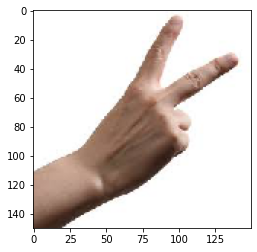


The image is detected as Scissor


    Product  Probability
0     Paper     0.037916
1      Rock     0.001240
2  Scissors     0.960844




In [25]:
uploaded = files.upload()

for fn in uploaded.keys():
  path = fn
  img = image.load_img(path, target_size=(150,150))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  img = np.vstack([x])

label, df = predict_image(img)

print('\n')
plt.show()
print("\nThe image is detected as " + label)
print('\n')
print(df)
print('\n')